In [3]:
import numpy as np
import math
import numba as nb
import matplotlib.pyplot as plt
import emcee
from emcee.autocorr import integrated_time
from corner import corner
from scipy.integrate import simpson,dblquad
import torch

torch.set_default_dtype(torch.float32)

#%matplotlib ipympl
%matplotlib inline

In [4]:
def logP(X):
    return -np.sum(100*(X[1:]-X[:-1]**2)**2 + (1-X[:-1])**2,axis=0)

def MMC(logP,X0,sig,n_iter):
    X=np.array(X0)
    ps=np.zeros((n_iter,*X0.shape))
    accepted=np.zeros(X0.shape[1])
    for i in range(n_iter):
        Y= np.random.normal(X,sig)
        T= logP(Y)-logP(X)
        ids= np.where((T>np.log(np.random.uniform(0,1))))
        X[:,ids]= Y[:,ids]
        accepted[ids]+= 1 
        ps[i]= X
    accept_ratio= accepted/n_iter
    return ps.T,accept_ratio


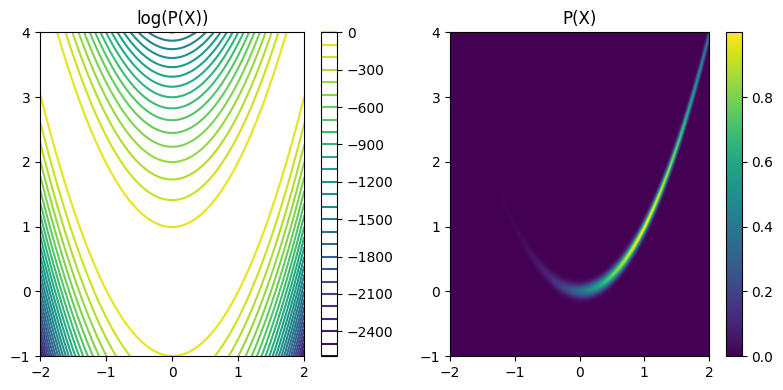

In [5]:
xs= np.linspace(-2,2,1000)
ys= np.linspace(-1,4,1000)
x_mesh,y_mesh=np.meshgrid(xs,ys)
X= np.stack((x_mesh,y_mesh),axis=0)

logPs= logP(X)
fig= plt.figure(figsize=(8,4))
ax= fig.add_subplot(1,2,1)
cntr= ax.contour(x_mesh,y_mesh,logPs,levels=30,cmap='viridis')
#im=ax.imshow((Ps.reshape(x_mesh.shape)),extent=[xs[0],xs[-1],ys[0],ys[-1]],origin='lower')
ax.set_title('log(P(X))')
plt.colorbar(cntr)

ax2= fig.add_subplot(1,2,2)
#ax2.plot_surface(x_mesh,y_mesh,Ps.reshape(x_mesh.shape),cmap='viridis')
im=ax2.imshow((np.exp(logPs)),extent=[xs[0],xs[-1],ys[0],ys[-1]],origin='lower')
plt.colorbar(im)
ax2.set_title('P(X)')

plt.tight_layout()

In [6]:
xs= np.linspace(-6,6,5000)
ys= np.linspace(-3,15,5000)
x_mesh,y_mesh=np.meshgrid(xs,ys)
X= np.stack((x_mesh,y_mesh),axis=0)

logPs= logP(X)
Ps= np.exp(logPs)
print(simpson(simpson(Ps,x=ys),x=xs))
quadf= lambda y,x: np.exp(logP(np.vstack((x,y))))
print(dblquad(quadf,-6,6,-3,15))


0.31415164431883763
(0.31415163725253026, 1.4780011827536648e-08)


In [16]:
dim=3
N=600
lim= [-30,30]
xs= np.linspace(*lim,N)
X= np.stack(np.meshgrid(*[xs for i in range(dim)]),axis=0)
Ps= np.exp(logP(X))

In [17]:
#Normalising P
N= Ps
for i in range(dim):
    N= simpson(N,x=xs)

print(N)

Ps= Ps/N

0.3141592653208371


In [18]:
#Finding |X| numerically

intgrl= np.sqrt(np.sum(X**2,axis=0))*Ps
for i in range(dim):
    intgrl=simpson(intgrl,x=xs)
    
print(intgrl)

1.874070799602118


In [44]:
n_chains=100
n_iter=1000000
X0= np.random.uniform(-2,2,(dim,n_chains))
chains,ratio= MMC(logP,X0,0.1,n_iter)
print(ratio.mean())

0.21839517


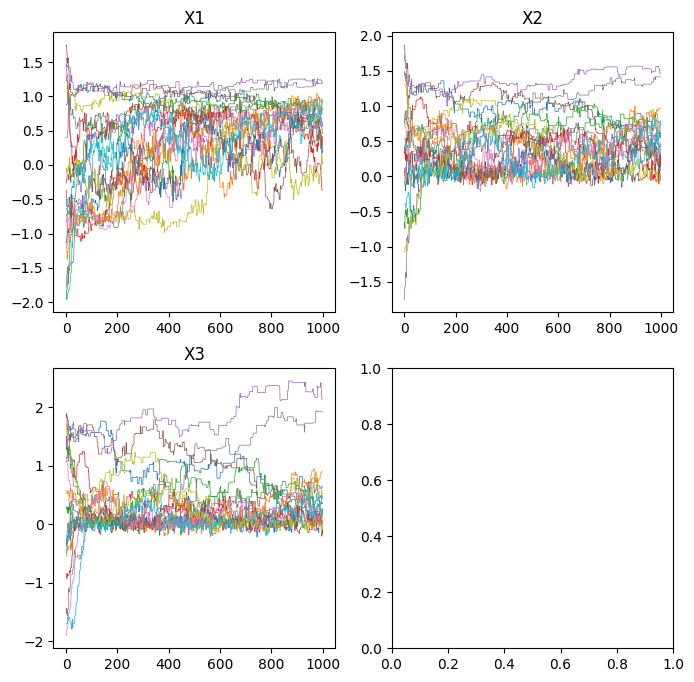

In [45]:
plot_first=1000

fig,axs=plt.subplots(math.ceil(dim/2),2,figsize=(8,4*math.ceil(dim/2)))
axs= axs.flatten()


for i in range(dim):
    for k in range(20):
        axs[i].plot(np.arange(0,plot_first),chains[k,i,:plot_first],lw=0.5)
        axs[i].set_title('X'+str(i+1))


In [46]:
burn_in=500
chains=chains[:,:,burn_in:]

In [47]:
#corner(np.hstack(chains).T)
#plt.show()

In [48]:
autocorr_time= integrated_time(np.transpose(chains[:20],axes=(2,0,1)))
print(autocorr_time)
tau= autocorr_time.max()

[ 5476.63935957  9431.60705093 12626.73574502]


In [49]:
thinned_chain= np.hstack(chains[:,:,::int(2.5*tau)])
n_samples= thinned_chain.shape[1]
print(n_samples)

3200


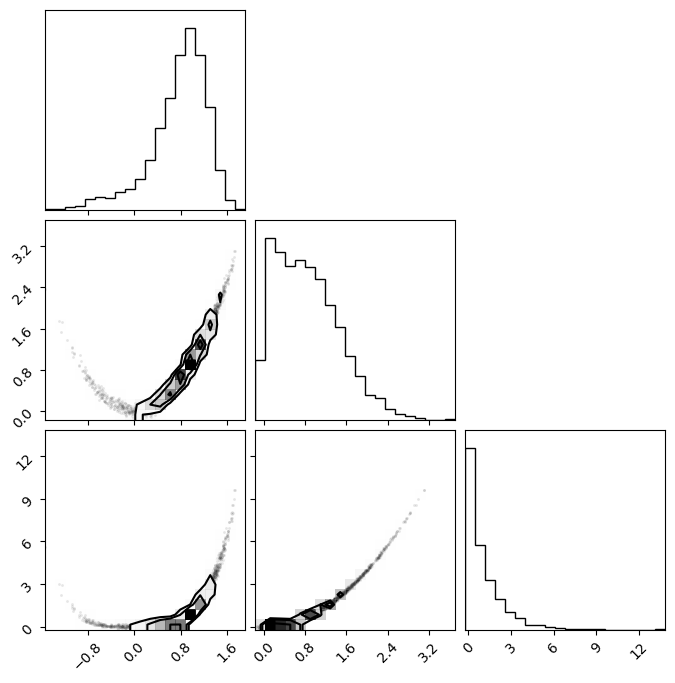

In [50]:
corner(thinned_chain.T)
plt.show()

In [51]:
#Calculating the expectation as a mean of means problem
mod_X= np.sqrt(np.sum(chains**2,axis=1))
means_X= np.mean(mod_X,axis=1)
mean_means= np.mean(means_X)
var_means= np.var(means_X,ddof=1)
std_mean_means= (var_means/n_chains)**0.5
print(f"Mean: {mean_means:.5f},\nUncertainty on mean: {std_mean_means:.5f}")

Mean: 1.73884,
Uncertainty on mean: 0.02342


In [52]:
#Calcuating the expectation from i.i.d samples
mod_X= np.sqrt(np.sum(thinned_chain**2,axis=0))
mean_X= np.mean(mod_X)
var_X= np.var(mod_X,ddof=1)
std_mean= (var_X/n_samples)**0.5
print(f"Mean: {mean_X:.5f},\nUncertainty on mean: {std_mean:.5f}")

Mean: 1.70162,
Uncertainty on mean: 0.02545


In [53]:
n_chains=100
n_iter=100000
X0= np.random.uniform(-2,2,(n_chains,dim))
log_P= lambda x: logP(x.T)
sampler= emcee.EnsembleSampler(n_chains,dim,log_P,vectorize=True)
state= sampler.run_mcmc(X0,n_iter)
print(sampler.acceptance_fraction.mean())

0.3704003


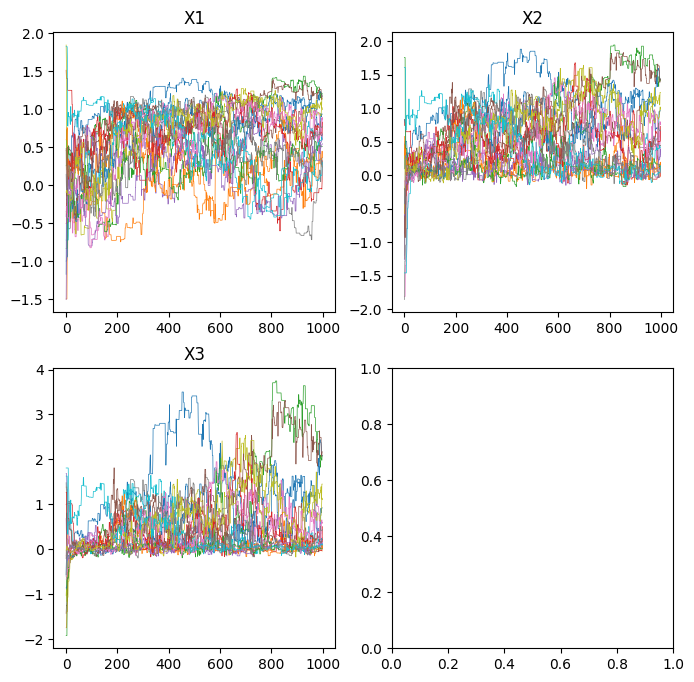

In [ ]:
plot_first=1000

fig,axs=plt.subplots(math.ceil(dim/2),2,figsize=(8,4*math.ceil(dim/2)))
axs= axs.flatten()


for i in range(dim):
    for k in range(20):
        axs[i].plot(np.arange(0,plot_first),sampler.get_chain()[:plot_first,k,i],lw=0.5)
        axs[i].set_title('X'+str(i+1))

In [55]:
burn_in=200

In [56]:
autocorr_time= sampler.get_autocorr_time()
print(autocorr_time)
tau= autocorr_time.max()

[1033.22647095  637.89091564  725.13153327]


In [57]:
thinned_chain= sampler.get_chain(flat=True,discard=burn_in,thin=int(2.5*tau))
n_samples= thinned_chain.shape[0]
print(n_samples)


3800


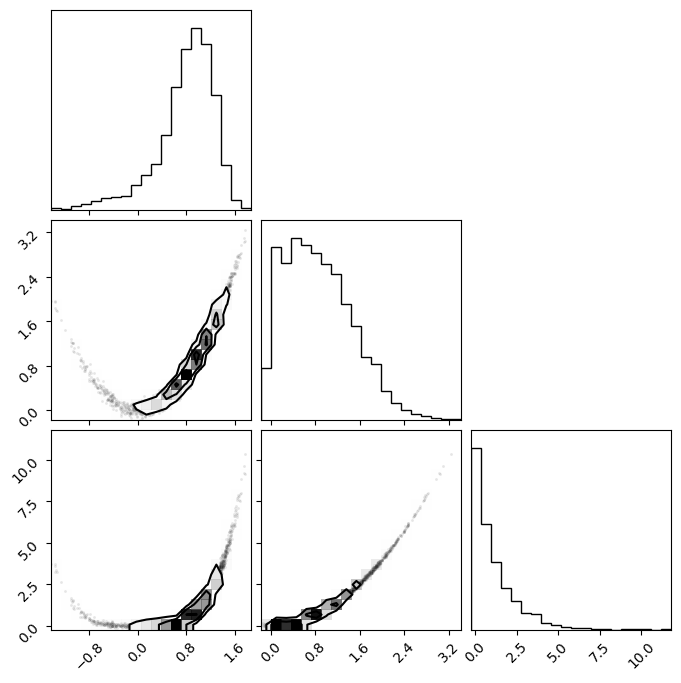

In [58]:
corner(thinned_chain)
plt.show()

In [59]:
#Calculating the expectation as a mean of means problem
chains= np.transpose(sampler.get_chain(),axes=(1,2,0))

mod_X= np.sqrt(np.sum(chains**2,axis=1))
means_X= np.mean(mod_X,axis=1)
mean_means= np.mean(means_X)
var_means= np.var(means_X,ddof=1)
std_mean_means= (var_means/n_chains)**0.5
print(f"Mean: {mean_means:.5f},\nUncertainty on mean: {std_mean_means:.5f}")

Mean: 1.69991,
Uncertainty on mean: 0.01513


In [60]:
#Calcuating the expectation from i.i.d samples
thinned_chain= thinned_chain.T

mod_X= np.sqrt(np.sum(thinned_chain**2,axis=0))
mean_X= np.mean(mod_X)
var_X= np.var(mod_X,ddof=1)
std_mean= (var_X/n_samples)**0.5
print(f"Mean: {mean_X:.5f},\nUncertainty on mean: {std_mean:.5f}")

Mean: 1.72249,
Uncertainty on mean: 0.02265


In [465]:
def logP(X):
    return -torch.sum(100*(X[1:]-X[:-1]**2)**2 + (1-X[:-1])**2,axis=0)
    

#Implementing Hamiltonian Monte Carlo as a class
class HMC():
    def __init__(self,n_chains,n_dims,logP,M,grad=None):
        self.logP= logP
        self.n_chains=n_chains
        self.n_dims= n_dims
        self.M_inv= torch.linalg.inv(M) 
        if grad==None:
            self.has_grad=False 
        else:
            self.has_grad=True
            self.grad=grad

        self.ones= torch.ones(n_chains)
        self.prop_mean= torch.zeros(n_dims)
        self.chains=None
        

    def _verlet_with_grad(self,X,P,n_steps,h):
        P-= (h/2)*self.grad(X)
        for i in range(n_steps):
            X-= h*(self.M_inv@P)
            P-= h*self.grad(X)

        P+= (h/2)*self.grad(X)
        return X,P

    def _verlet_without_grad(self,X,P,n_steps,h):
        x= X.clone().detach().requires_grad_(True)
        Y= logP(x)
        Y.backward(self.ones)
        P-= (h/2)*x.grad 
        for i in range(n_steps-1):
            with torch.no_grad():
                x-= (h*self.M_inv)@P
            x.grad.zero_()
            Y= logP(x)
            Y.backward(self.ones)
            P-= h*x.grad

        P+= (h/2)*x.grad
        return x.detach(),P
    
    def run_mcmc(self,X,n_iter,n_evols,evol_step):
        self.chains= torch.zeros(n_iter,self.n_dims,self.n_chains)
        self.accept_ratio= torch.zeros(self.n_chains)
        if self.has_grad==True:
            evolve= self._verlet_with_grad 
        else:
            evolve= self._verlet_without_grad

        M_inv_np= self.M_inv.numpy()
        mean_np= self.prop_mean.numpy()
        
        for i in range(n_iter):
            P= torch.tensor(np.random.multivariate_normal(mean_np,M_inv_np,size=self.n_chains),requires_grad=False).T
            H_i= -logP(X)+ torch.sum((P.T@self.M_inv).T*P,axis=0)/2
            Y,P= evolve(X,P,n_evols,evol_step)
            H_f= -logP(Y)+ torch.sum((P.T@self.M_inv).T*P,axis=0)/2
            ids= torch.where(H_i-H_f>np.log(np.random.uniform(0,1)))[0]
            X[:,ids]= Y[:,ids]
            self.accept_ratio[ids]+= 1
            self.chains[i]=X
        self.accept_ratio /= n_iter

In [592]:
n_chains=100
n_iter=10000
n_evols=20
evol_step= 0.02
M= torch.eye(dim)
X0= torch.tensor(np.random.uniform(-2,2,(dim,n_chains)),requires_grad=False)
sampler= HMC(n_chains,dim,logP,M)
sampler.run_mcmc(X0,n_iter,n_evols,evol_step)
sampler.accept_ratio.mean()

tensor(0.9500)

In [593]:
chains= sampler.chains.numpy().T

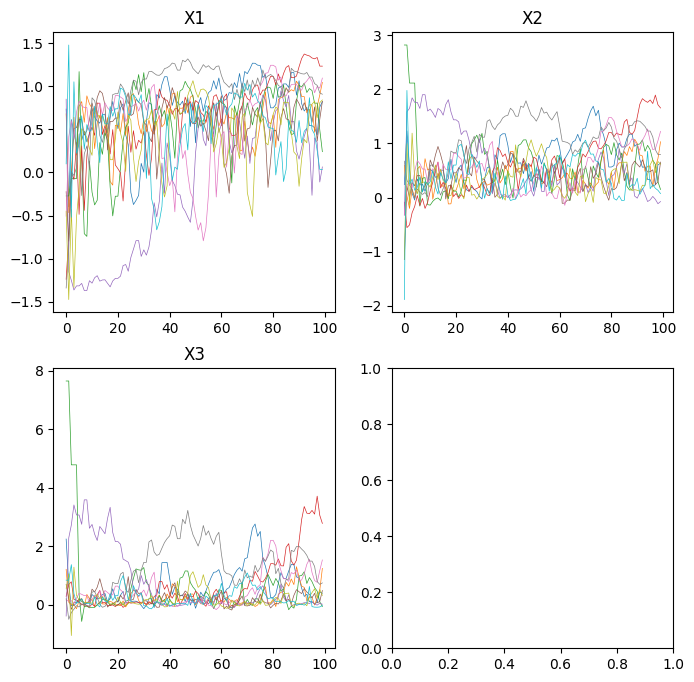

In [594]:
plot_first=100
fig,axs=plt.subplots(math.ceil(dim/2),2,figsize=(8,4*math.ceil(dim/2)))
axs= axs.flatten()


for i in range(dim):
    for k in range(10):
        axs[i].plot(np.arange(0,plot_first),chains[k,i,:plot_first],lw=0.5)
        axs[i].set_title('X'+str(i+1))

In [595]:
burn_in=20
chains= chains[:,:,burn_in:]

In [596]:
autocorr_time= integrated_time(np.transpose(chains[:20],axes=(2,0,1)))
print(autocorr_time)
tau= autocorr_time.max()

[54.78924597 74.73281182 88.07929996]


In [597]:
thinned_chain= np.hstack(chains[:,:,::int(2.5*tau)])
n_samples= thinned_chain.shape[1]
print(n_samples)

4600


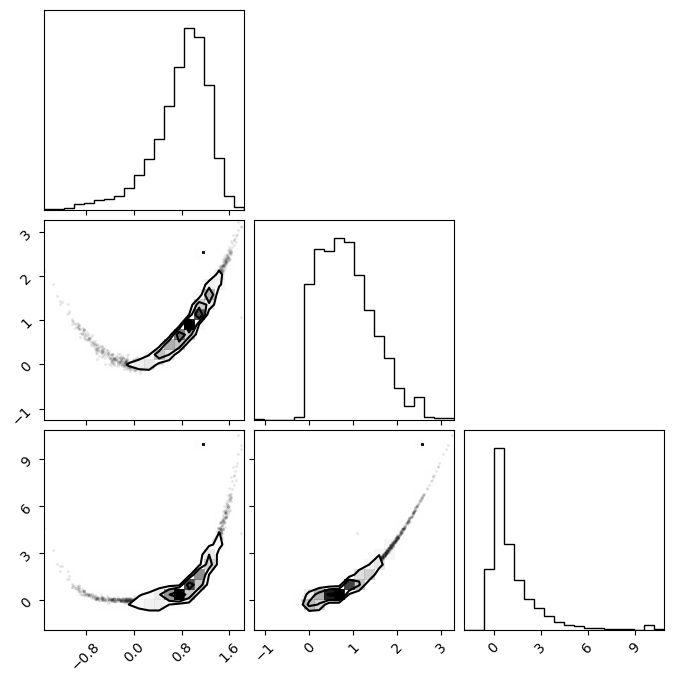

In [598]:
corner(thinned_chain.T)
plt.show()

In [599]:
#Calculating the expectation as a mean of means problem
mod_X= np.sqrt(np.sum(chains**2,axis=1))
means_X= np.mean(mod_X,axis=1)
mean_means= np.mean(means_X)
var_means= np.var(means_X,ddof=1)
std_mean_means= (var_means/n_chains)**0.5
print(f"Mean: {mean_means:.5f},\nUncertainty on mean: {std_mean_means:.5f}")

Mean: 1.77470,
Uncertainty on mean: 0.08771


In [600]:
#Calcuating the expectation from i.i.d samples
mod_X= np.sqrt(np.sum(thinned_chain**2,axis=0))
mean_X= np.mean(mod_X)
var_X= np.var(mod_X,ddof=1)
std_mean= (var_X/n_samples)**0.5
print(f"Mean: {mean_X:.5f},\nUncertainty on mean: {std_mean:.5f}")

Mean: 1.75937,
Uncertainty on mean: 0.02376
